## Let's implement CCS from scratch.
This will deliberately be a simple (but less efficient) implementation to make everything as clear as possible.

In [2]:
# my cool cool imports
import matplotlib.pyplot as plt
import random
import pickle

In [3]:
from tqdm import tqdm
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForMaskedLM, AutoModelForCausalLM
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC



/opt/conda/envs/ccs2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# QNLI dataset!
# data = load_dataset("amazon_polarity")["test"]
data = load_dataset("glue", "qnli")["train"]

Generating test split: 100%|██████████| 5463/5463 [00:00<00:00, 34517.61 examples/s]


In [6]:
# COPA dataset
data = load_dataset("super_glue", "copa")

Generating test split: 100%|██████████| 500/500 [00:00<00:00, 25483.97 examples/s]


In [4]:
# BOOLQ dataset
data = load_dataset("super_glue", "boolq")["train"]

Generating test split: 100%|██████████| 3245/3245 [00:00<00:00, 32940.01 examples/s]


In [8]:
# manually executes model choice!
model_type = "encoder"
# MODEL_NAME = "microsoft/deberta-v2-xxlarge"
MODEL_NAME = "microsoft/deberta-v3-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
model.cuda()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/envs/ccs2/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of DebertaV2ForMaskedLM were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias',

DebertaV2ForMaskedLM(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
       

## First let's write code for extracting hidden states given a model and text. 
How we do this exactly will depend on the type of model.

In [9]:
def get_encoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given an encoder model and some text, gets the encoder hidden states (in a given layer, by default the last) 
    on that input text (where the full text is given to the encoder).

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize
    encoder_text_ids = tokenizer(input_text, truncation=True, return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(encoder_text_ids, output_hidden_states=True)

    # get the appropriate hidden states
    hs_tuple = output["hidden_states"]
    
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()

    return hs

def get_encoder_decoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given an encoder-decoder model and some text, gets the encoder hidden states (in a given layer, by default the last) 
    on that input text (where the full text is given to the encoder).

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize
    encoder_text_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(model.device)
    decoder_text_ids = tokenizer("", return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(encoder_text_ids, decoder_input_ids=decoder_text_ids, output_hidden_states=True)

    # get the appropriate hidden states
    hs_tuple = output["encoder_hidden_states"]
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()

    return hs

def get_decoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given a decoder model and some text, gets the hidden states (in a given layer, by default the last) on that input text

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize (adding the EOS token this time)
    input_ids = tokenizer(input_text + tokenizer.eos_token, return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(input_ids, output_hidden_states=True)

    # get the last layer, last token hidden states
    hs_tuple = output["hidden_states"]
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()

    return hs

def get_hidden_states(model, tokenizer, input_text, layer=-1, model_type="encoder"):
    fn = {"encoder": get_encoder_hidden_states, "encoder_decoder": get_encoder_decoder_hidden_states,
          "decoder": get_decoder_hidden_states}[model_type]

    return fn(model, tokenizer, input_text, layer=layer)

In [10]:
# specifies embedding fn
# default model_type = "encoder" is fine, since we use deberta
EMBEDDING_FN = lambda input_text: get_hidden_states(model, tokenizer, input_text)

## Now let's write code for formatting data and for getting all the hidden states.

In [34]:
# formats an individual exaple
def format_boolq(passage, question, label):

    return f"""
PASSAGE: {passage}
QUESTION: {question}
ANSWER: {label}
"""

In [53]:
# featurizes the entire dataset
def featurizer_benchmark(data):

    # featurizes an individual example
    def featurizer(passage, question):
        return EMBEDDING_FN(format_boolq(passage, question, 1)) - EMBEDDING_FN(format_boolq(passage, question, 0))

    # featurizes the entire dataset
    features = []
    for i in tqdm(range(len(data["passage"]))):
        passage = data["passage"][i]
        question = data["question"][i]
        features.append(featurizer(passage, question))

    return features

In [54]:
# specifies featurizer fn
FEATURIZER_FN = featurizer_benchmark

In [75]:
# subsamples dataset
N = 5000
subsample = data[np.random.choice(len(data), N, replace=False)]

In [76]:
# featurizes subsample
X = np.array(FEATURIZER_FN(subsample))
y = np.array(subsample["label"])

In [14]:
# pickles and saves X
# pickle.dump(X, open('X.pkl', 'wb'))

# reads X from pickle
# X = pickle.load(open('X.pkl', 'rb'))

In [ ]:
# gets difference of means
exgy = X[y == 1].mean(axis = 0)
exgn = X[y == 0].mean(axis = 0)
diff = exgy - exgn

# Metrics
- salience (proportion of X explained by diff)
<!-- - power (proportion of y explained by diff) -->
- accuracy (proportion of correct predictions)

In [ ]:
# gets covariance matrix of X
cmx = np.cov(X.T)

# gives salienece as rayleigh quotient w normalized trace
# = e.val / sum e.vals
print("salience: ", np.round(diff.T @ cmx @ diff / diff.dot(diff) / np.trace(cmx), 2))

salience:  0.53


In [ ]:
# overall mean x
ex = X.mean(axis = 0)

# gets vector of diff scores
X_diffs = (X - ex) @ diff

# gets sign of diff scores
X_signs = np.sign(X_diffs)

(array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  3.,  0.,  1.,  0.,  1.,
          3.,  3.,  3.,  5.,  7.,  5.,  9., 11., 15., 14., 26., 22., 37.,
         54., 42., 53., 46., 50., 47., 47., 23., 22.,  7., 11.,  6.,  7.,
          2.,  1.,  0.,  1.,  2.,  1.,  1.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  2.,  1.,  1.,  1.,  0.,  1.,  0.,  2.,  1.,
          1.,  2.,  5.,  5.,  6.,  8.,  5.,  5., 17., 17., 15., 29., 28.,
         33., 30., 40., 28., 26., 26., 22., 19.,  7.,  3.,  3.,  5.,  6.,
          0.,  1.,  2.,  0.,  1.,  0.,  2.,  0.,  1.,  0.,  1.]]),
 array([-7.99437054e-03, -7.70675065e-03, -7.41913076e-03, -7.13151088e-03,
        -6.84389146e-03, -6.55627158e-03, -6.26865169e-03, -5.98103181e-03,
        -5.69341192e-03, -5.40579204e-03, -5.11817215e-03, -4.83055273e-03,
        -4.54293285e-03, -4.25531296e-03, -3.96769308e-03, -3.68007319e-03,
        -3.39245331e-03, -3.10483365e-03, -2.81721377e-03, -2.52959388e-03,
        -2.24197423e-03, -1.95435435e-03, -1

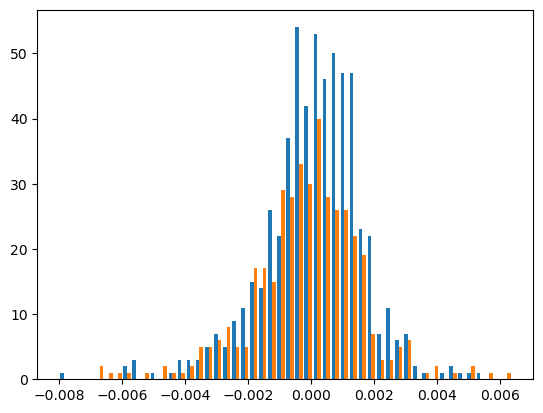

In [ ]:
# plots diff scores for positive and negative examples
import matplotlib.pyplot as plt
diff_y = X_diffs[y == 1]
diff_n = X_diffs[y == 0]

plt.hist([diff_y, diff_n], bins=50, label=['positive', 'negative'])

In [ ]:
# converts y to (1, -1) vector
y_signs = np.where(y == 0, -1, 1)

# gets Pr[correct]
pr_correct = (X_signs.dot(y_signs) / len(y_signs) + 1) / 2
print("classifier accuracy: ", np.round(pr_correct, 2))

classifier accuracy:  0.55


In [ ]:
# alternatively, just gets sklearn to do it
lr = LogisticRegression(class_weight='balanced')
lr.fit(X, y)
print("Logistic regression accuracy: {}".format(lr.score(X, y)))

Logistic regression accuracy: 0.566


In [ ]:
# SVM!!!
svc = SVC(class_weight="balanced")
svc.fit(X, y)
print("SVM accuracy: {}".format(svc.score(X, y)))

SVM accuracy: 0.663


In [72]:
from sklearn.svm import SVC

(array([[  0.,   0.,   4.,   7.,  13.,  42.,  51.,  61.,  88., 211.],
        [302., 221.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([-0.14896262, -0.03408197,  0.08079867,  0.19567932,  0.31055996,
         0.42544061,  0.54032125,  0.65520189,  0.77008254,  0.88496318,
         0.99984383]),
 <a list of 2 BarContainer objects>)

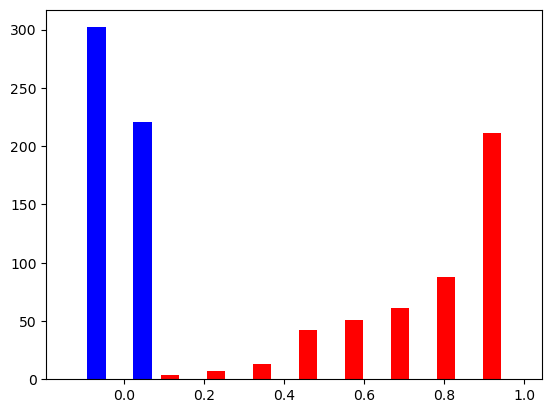

In [20]:
# plots LR predictions by class
preds = lr.predict_proba(X)[:, 1]
preds_y = preds[y == 1]
preds_n = X_diffs[y == 0]

plt.hist([preds_y, preds_n], bins=10, label=['positive', 'negative'], color = ["red", "blue"])